Hello World!

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import attila_utils
from bsmcalls import SNPnexus
from bsmcalls import operations
from bsmcalls import resources
from bsmcalls import individuals
from bsmcalls import preprocessing
from bsmcalls import stats as bsmstats
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels import graphics as smg
from statsmodels.graphics import regressionplots
from statsmodels.graphics import dotplots
import patsy
import scipy.stats as stats
import indiv_counts_modeling as icm
%matplotlib inline

## Preliminary
First we read in our annotated callset to the `data` DataFrame.  I import the schizophrenia GWAS genes too.

In [2]:
data = SNPnexus.load_data('/home/attila/projects/bsm/results/2020-09-07-annotations/annotated-calls.p')
clozukpath = '/home/attila/projects/bsm/resources/CLOZUK/supp-table-4.csv'
gwasgenes = operations.get_geneset(df=pd.read_csv(clozukpath, skiprows=7), col='Gene(s) tagged')

Now the we query the annotated callset with a set of queries for annotations from `near_gens_Annotation` to `near_gens_Overlapped`.  This creates detailed `results` as well as a `summary` showing the number of calls in each category for each Dx.

In [3]:
# near_gens
querydict = {'near_gens_Annotation': ['coding nonsyn', 'coding syn', 'missense', 'stop-gain', 'intronic (splice_site)'],
             'ensembl_Predicted Function': ['coding'],
             'sift_Prediction': ['Deleterious', 'Deleterious - Low Confidence'],
             'polyphen_Prediction': ['Probably Damaging', 'Possibly Damaging'],
             'tfbs_TFBS Name': None,
             'phast_Score': None,
             'gerp_Element RS Score': None,
             'cpg_CpG Island': None,
             'near_gens_Overlapped Gene': {'SCZ GWAS genes': gwasgenes},
            }
results = operations.multiquery(querydict, data, do_sum=False, do_sort=False)
summary = operations.summarize_query_results(results, data, chisq=False, margin=False)
summary#.style.bar(subset='chisq stat')

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Dx                                                       Control  SCZ  ASD
Feature                    Query                                          
near_gens_Annotation       coding nonsyn                      23   43   23
                           coding syn                         16   20   15
                           missense                            0    0    0
                           stop-gain                           1    0    0
                           intronic (splice_site)              0    1    0
ensembl_Predicted Function coding                             39   64   40
sift_Prediction            Deleterious                         8    9    6
                           Deleterious - Low Confidence        1    1    2
polyphen_Prediction        Probably Damaging                   3    5    2
                           Possibly Damaging                   2    2    0
tfbs_TFBS Name             any                                48   78   50
phast_Score                any                               102  174  141
gerp_Element RS Score      any                               140  262  208
cpg_CpG Island             any                                26   47   19
near_gens_Overlapped Gene  SCZ GWAS genes                     20   66   42

Repeat the operaton but excluding ASD individuals.

In [4]:
results_scz = operations.multiquery(querydict, preprocessing.drop_category(data, 'ASD'), do_sum=False, do_sort=False)
#results_scz['Dx'] = preprocessing.drop_category(data, 'ASD')['Dx'] # this in place modification is implicitly done in operations.summarize_query_results
summary_scz = operations.summarize_query_results(results_scz, preprocessing.drop_category(data, 'ASD'), chisq=False, margin=False)

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


## Detour: two closely related chi^2 tests

Here we look at two cloesely related ways of obtaining the expected counts for the chi^2 test.  For a given Dx the expected counts may be based on:
1. `ncalls` the number of calls across all individuals
1. `nsamples` the number of individuals

The comparison below shows that thet two methods yield similar results

In [5]:
def compare_ncalls_nsamples_chisq(data, results, summary):
    d = {'ncalls': data.groupby('Dx').size(), 'nsamples': individuals.get_nsamples(results)}
    dfd = {k: operations.chisquare_summary(summary, expected_odds, append=False) for k, expected_odds in d.items()}
    dfl = [pd.DataFrame(df.to_numpy(), columns=pd.MultiIndex.from_product([[k], df.columns]), index=df.index) for k, df in dfd.items()]
    df = pd.concat(dfl, axis=1)
    return((df, d))

df, ncalls_nsamples = compare_ncalls_nsamples_chisq(data, results, summary)
summary_chisq = df.xs('ncalls', axis=1) # for later use
df

/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


ncalls            \
                                                        chisq stat   chisq p   
Feature                    Query                                               
near_gens_Annotation       coding nonsyn                  4.480340  0.106440   
                           coding syn                     1.177849  0.554924   
                           missense                            NaN       NaN   
                           stop-gain                      2.887477  0.236044   
                           intronic (splice_site)         1.582797  0.453210   
ensembl_Predicted Function coding                         3.794387  0.149989   
sift_Prediction            Deleterious                    1.315056  0.518131   
                           Deleterious - Low Confidence   0.429823  0.806613   
polyphen_Prediction        Probably Damaging              1.080625  0.582566   
                           Possibly Damaging              2.470275  0.290795   
tfbs_TFBS Name             any                            4.120011  0.127453   
phast_Score                any                            1.591145  0.451323   
gerp_Element RS Score      any                            5.012216  0.081585   
cpg_CpG Island             any                            9.614759  0.008169   
near_gens_Overlapped Gene  SCZ GWAS genes                10.800565  0.004515   

                                                          nsamples            
                                                        chisq stat   chisq p  
Feature                    Query                                              
near_gens_Annotation       coding nonsyn                  4.765326  0.092304  
                           coding syn                     1.371564  0.503696  
                           missense                            NaN       NaN  
                           stop-gain                      2.950000  0.228779  
                           intronic (splice_site)         1.590164  0.451544  
ensembl_Predicted Function coding                         4.219225  0.121285  
sift_Prediction            Deleterious                    1.451859  0.483875  
                           Deleterious - Low Confidence   0.406971  0.815882  
polyphen_Prediction        Probably Damaging              1.139182  0.565757  
                           Possibly Damaging              2.540164  0.280809  
tfbs_TFBS Name             any                            4.620352  0.099244  
phast_Score                any                            1.763406  0.414077  
gerp_Element RS Score      any                            4.990139  0.082491  
cpg_CpG Island             any                           10.092813  0.006432  
near_gens_Overlapped Gene  SCZ GWAS genes                10.690924  0.004770

In [6]:
df, ncalls_nsamples_scz = compare_ncalls_nsamples_chisq(preprocessing.drop_category(data, 'ASD'), results_scz, summary_scz)
#summary_chisq = df.xs('ncalls', axis=1) # for later use
df

/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


ncalls            \
                                                        chisq stat   chisq p   
Feature                    Query                                               
near_gens_Annotation       coding nonsyn                  0.707206  0.400373   
                           coding syn                     0.307556  0.579184   
                           missense                            NaN       NaN   
                           stop-gain                      1.505142  0.219882   
                           intronic (splice_site)         0.664389  0.415015   
ensembl_Predicted Function coding                         0.181154  0.670383   
sift_Prediction            Deleterious                    0.361448  0.547703   
                           Deleterious - Low Confidence   0.084766  0.770940   
polyphen_Prediction        Probably Damaging              0.019501  0.888940   
                           Possibly Damaging              0.169531  0.680529   
tfbs_TFBS Name             any                            0.174529  0.676118   
phast_Score                any                            1.009212  0.315092   
gerp_Element RS Score      any                            4.346044  0.037095   
cpg_CpG Island             any                            0.563172  0.452985   
near_gens_Overlapped Gene  SCZ GWAS genes                 9.955066  0.001604   

                                                          nsamples            
                                                        chisq stat   chisq p  
Feature                    Query                                              
near_gens_Annotation       coding nonsyn                  0.624000  0.429565  
                           coding syn                     0.352641  0.552622  
                           missense                            NaN       NaN  
                           stop-gain                      1.525000  0.216864  
                           intronic (splice_site)         0.655738  0.418069  
ensembl_Predicted Function coding                         0.130356  0.718063  
sift_Prediction            Deleterious                    0.394986  0.529690  
                           Deleterious - Low Confidence   0.090369  0.763709  
polyphen_Prediction        Probably Damaging              0.014805  0.903155  
                           Possibly Damaging              0.180738  0.670740  
tfbs_TFBS Name             any                            0.119906  0.729136  
phast_Score                any                            0.808749  0.368490  
gerp_Element RS Score      any                            3.836963  0.050134  
cpg_CpG Island             any                            0.485268  0.486046  
near_gens_Overlapped Gene  SCZ GWAS genes                 9.609226  0.001936

['named-figure/ncall_nindiv_count-Dx.png',
 'named-figure/ncall_nindiv_count-Dx.pdf']

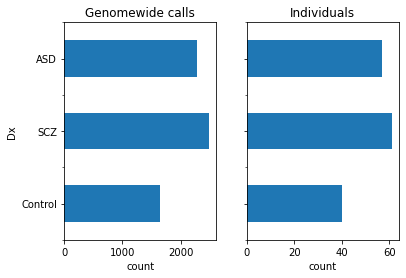

In [7]:
%matplotlib inline

def ncalls_nsamples_plot(ncalls_nsamples):
    fig, ax = plt.subplots(1, 2, sharey=True)
    ncalls_nsamples['ncalls'].plot(kind='barh', ax=ax[0])
    pd.Series(ncalls_nsamples['nsamples']).plot(kind='barh', ax=ax[1])
    ax[0].set_title('Genomewide calls')
    ax[1].set_title('Individuals')
    ax[0].set_xlabel('count')
    ax[1].set_xlabel('count')
    return((fig, ax))

fig, ax = ncalls_nsamples_plot(ncalls_nsamples)
attila_utils.savefig(fig, 'ncall_nindiv_count-Dx')

['named-figure/ncall_nindiv_count-Dx_scz.png',
 'named-figure/ncall_nindiv_count-Dx_scz.pdf']

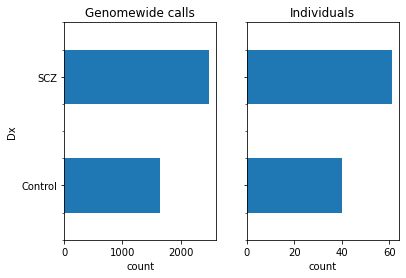

In [8]:
fig, ax = ncalls_nsamples_plot(ncalls_nsamples_scz)
attila_utils.savefig(fig, 'ncall_nindiv_count-Dx_scz')

## Limitations of the $\chi^2$ test

* univariate: it doesn't allow easy analysis of joint effects of multiple features
* counts of calls are the only possible variable to model

### Example: calls weighted by allele frequency

This piece of analysis shows that weighting each call with its allele frequency decreases significance of the $\chi^2$ test since the $\mathrm{AF} < 1$ (moreover $\mathrm{AF} \ll 1$ for most calls).

In [9]:
wncalls = data.groupby('Dx')['AF'].sum()
#wresults = results.drop(('Dx', ), axis=1).astype('int16').apply(lambda x: x * data['AF'], axis=0)
operations.chisquare_summary(summary, expected_odds=wncalls, append=False)

/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


chisq stat   chisq p
Feature                    Query                                             
near_gens_Annotation       coding nonsyn                   1.152128  0.562107
                           coding syn                      0.491868  0.781974
                           missense                             NaN       NaN
                           stop-gain                       2.675849  0.262390
                           intronic (splice_site)          1.330329  0.514189
ensembl_Predicted Function coding                          0.288166  0.865816
sift_Prediction            Deleterious                     0.673078  0.714238
                           Deleterious - Low Confidence    0.847928  0.654447
polyphen_Prediction        Probably Damaging               0.472640  0.789528
                           Possibly Damaging               2.006178  0.366745
tfbs_TFBS Name             any                             0.209300  0.900640
phast_Score                any                             3.446117  0.178519
gerp_Element RS Score      any                             7.684747  0.021443
cpg_CpG Island             any                             4.093641  0.129145
near_gens_Overlapped Gene  SCZ GWAS genes                  8.908390  0.011630

The same without ASD samples

In [10]:
wncalls_scz = preprocessing.drop_category(data, 'ASD').groupby('Dx')['AF'].sum()
operations.chisquare_summary(summary_scz, expected_odds=wncalls_scz, append=False)

/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


chisq stat   chisq p
Feature                    Query                                             
near_gens_Annotation       coding nonsyn                   0.433755  0.510152
                           coding syn                      0.483215  0.486970
                           missense                             NaN       NaN
                           stop-gain                       1.577395  0.209136
                           intronic (splice_site)          0.633957  0.425908
ensembl_Predicted Function coding                          0.037904  0.845635
sift_Prediction            Deleterious                     0.488456  0.484617
                           Deleterious - Low Confidence    0.105676  0.745122
polyphen_Prediction        Probably Damaging               0.005684  0.939903
                           Possibly Damaging               0.211351  0.645710
tfbs_TFBS Name             any                             0.026271  0.871239
phast_Score                any                             0.394524  0.529931
gerp_Element RS Score      any                             2.672295  0.102109
cpg_CpG Island             any                             0.311360  0.576847
near_gens_Overlapped Gene  SCZ GWAS genes                  8.749691  0.003097

## DataFrame for regression: `fitdata`

In [11]:
selcols = ['DP', 'BaseQRankSum', 'AF']
selcols_indiv = ['Dx', 'ageOfDeath', 'Dataset']
prettynames = ['coding_nonsyn', 'coding_syn', 'missense', 'stop_gain', 'splice_site', 'coding', 'deleterious', 'deleterious_low_confidence', 'probably_damaging', 'possibly_damaging', 'tfbs', 'phast', 'gerp', 'cpg_island', 'scz_gwas_genes']

def get_fitdata(data, results):
    covariates = data[selcols].groupby('Individual ID').mean()
    covariates[selcols_indiv] = data[selcols_indiv].groupby('Individual ID').first()
    covariates['ncalls'] = data.groupby('Individual ID').size()
    covariates = pd.concat([covariates, covariates['ncalls'].apply(np.log10).rename('log10_ncalls')], axis=1)
    Dxs = pd.Categorical(results[('Dx', )].groupby('Individual ID').first(), categories=results[('Dx', )].cat.categories)
    responses = results.drop(('Dx',), axis=1).groupby('Individual ID').sum()
    responses.columns = prettynames
    responses_prop = responses.apply(lambda x: x / covariates['ncalls'], axis=0).rename(lambda x: 'prop_' + x, axis=1)
    fitdata = pd.concat([responses, covariates], axis=1)
    return((fitdata, covariates, responses, responses_prop))

fitdata, covariates, responses, responses_prop = get_fitdata(data, results)
fitdata_scz, covariates_scz, responses_scz, responses_prop_scz = get_fitdata(preprocessing.drop_category(data, 'ASD'), results_scz)

/home/attila/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2923: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/attila/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


### Pairwise joint distributions

* No two variables show extremely tight dependence which implies limited collinearity in a normal or generalized linear model.
* The fraction of calls `fcalls_scz_gwas_genes` has very high variance when the total number of calls for an individual is low. This is undesirable.

/home/attila/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


['named-figure/symmetric-scatter-matrix.png',
 'named-figure/symmetric-scatter-matrix.pdf']

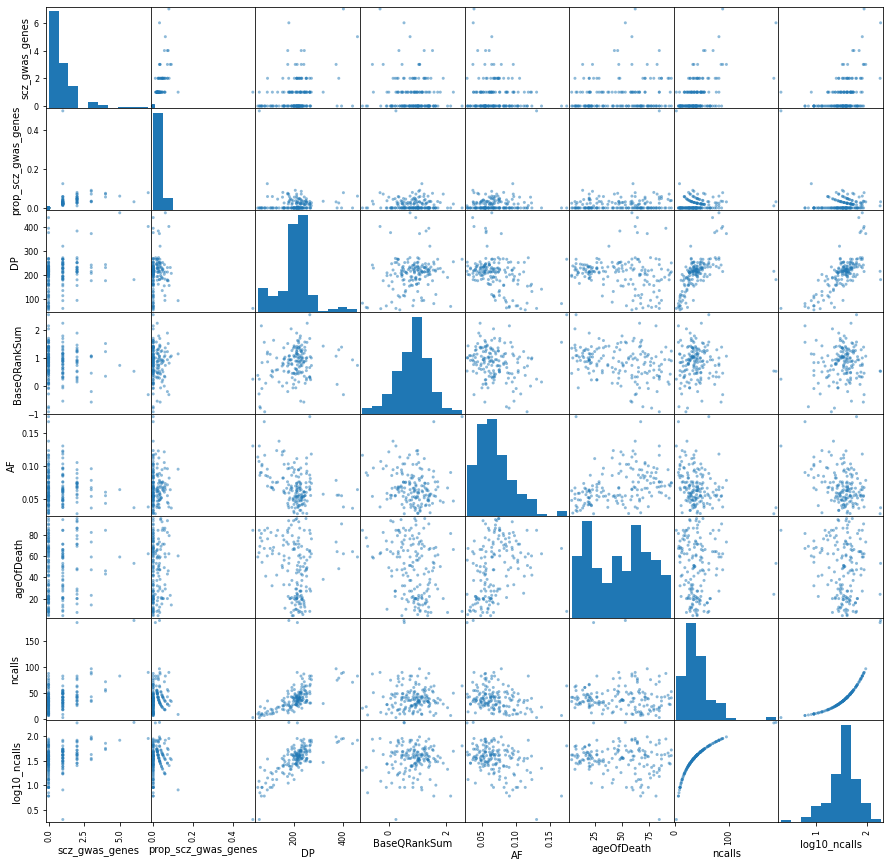

In [12]:
def scatter_matrix_plot(responses, responses_prop, covariates):
    df = pd.concat([responses['scz_gwas_genes'], responses_prop['prop_scz_gwas_genes'], covariates], axis=1)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax = pd.plotting.scatter_matrix(df, figsize=(15, 15), ax=ax)
    return((fig, ax))

fig, ax = scatter_matrix_plot(responses, responses_prop, covariates)
attila_utils.savefig(fig, 'symmetric-scatter-matrix')

The same plot without ASD samples

/home/attila/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


['named-figure/symmetric-scatter-matrix_scz.png',
 'named-figure/symmetric-scatter-matrix_scz.pdf']

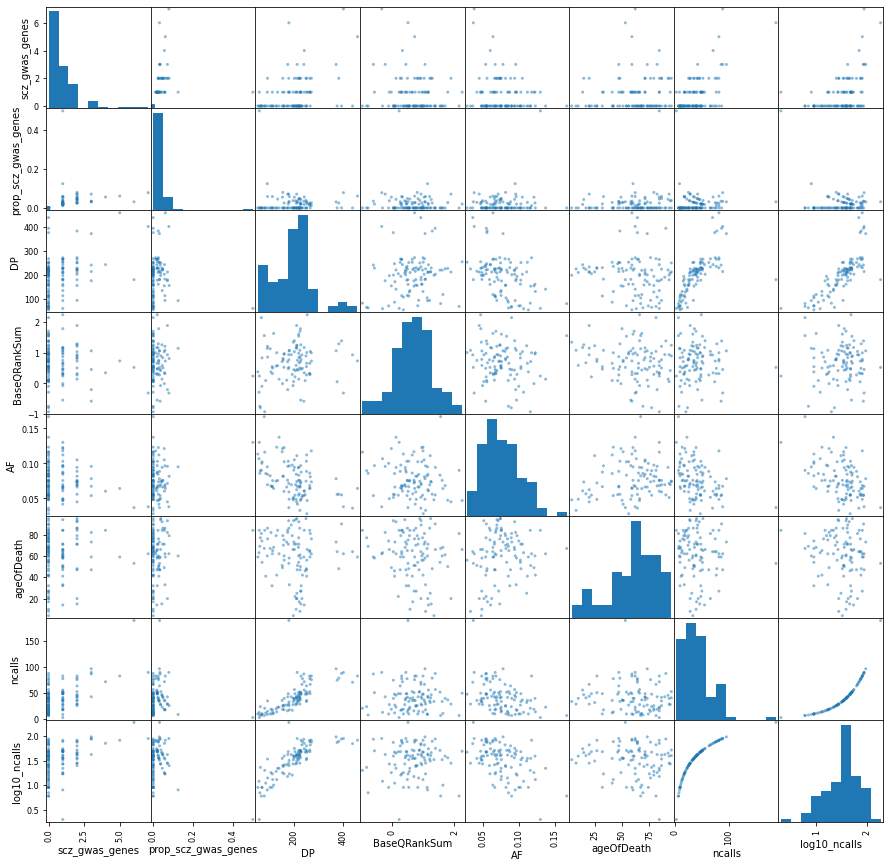

In [13]:
fig, ax = scatter_matrix_plot(responses_scz, responses_prop_scz, covariates_scz)
attila_utils.savefig(fig, 'symmetric-scatter-matrix_scz')

['named-figure/ncalls-scz_gwas_gene-ncalls.png',
 'named-figure/ncalls-scz_gwas_gene-ncalls.pdf']

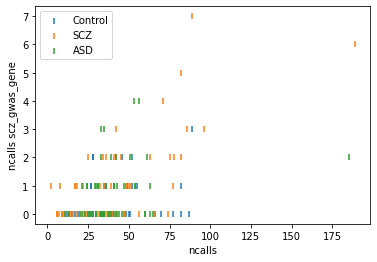

In [14]:
fig, ax = plt.subplots()
for Dx in ['Control', 'SCZ', 'ASD']:
    ax.scatter(x='ncalls', y='scz_gwas_genes', data=fitdata.loc[fitdata['Dx'] == Dx], marker='|', label=Dx)
ax.legend()
ax.set_xlabel('ncalls')
ax.set_ylabel('ncalls scz_gwas_gene')
attila_utils.savefig(fig, 'ncalls-scz_gwas_gene-ncalls')

## Multiple functional categories
### Response: ncalls in functional categ

Here the response (endogenous or dependent variable) is the number of calls per individual in some functinal category, and is plotted on the y axis.

The genome-wide number of calls per individual (`ncalls` or `log10_ncalls`) is regarded as an explanatory variable, and is plotted on the x axis.

['named-figure/ncalls-func-categ-predictors.png',
 'named-figure/ncalls-func-categ-predictors.pdf']

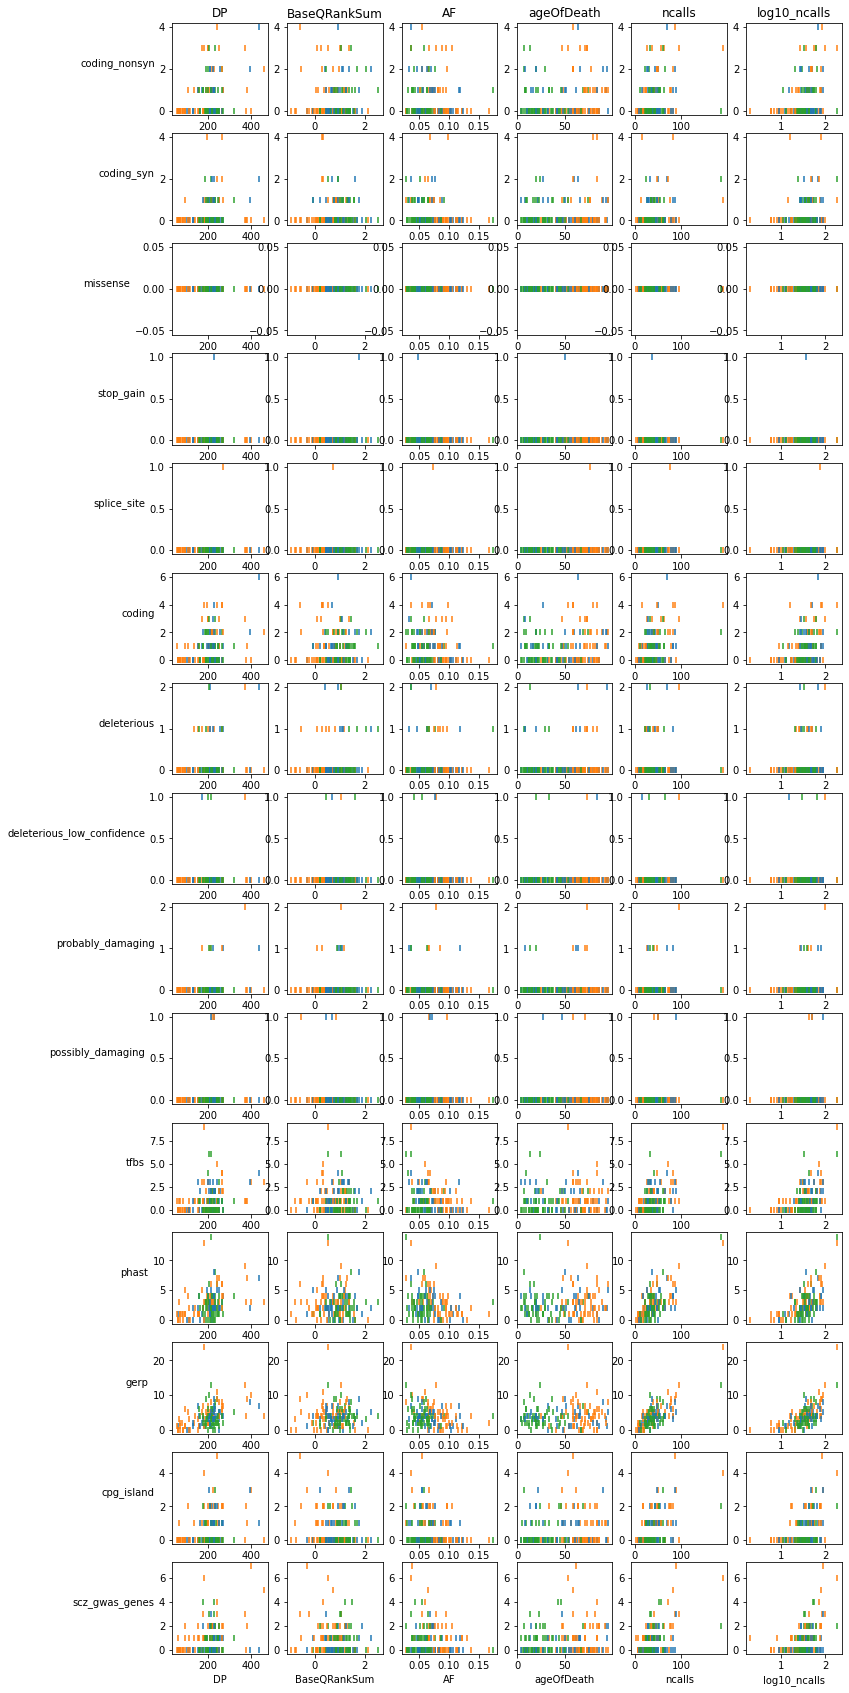

In [15]:
def getDxcol(fitdata):
    Dxs = fitdata['Dx'].copy()
    l = ['C' + str(x) for x in range(len(Dxs.cat.categories))]
    Dxcol = Dxs.cat.rename_categories(l)
    return(Dxcol)

def ncalls_categ_predictors_plot(fitdata, responses, covariates):
    Dxcol = getDxcol(fitdata)
    fig, ax = icm.big_plot_matrix(responses, covariates, Dxcol)
    return((fig, ax))

fig, ax = ncalls_categ_predictors_plot(fitdata, responses, covariates)
attila_utils.savefig(fig, 'ncalls-func-categ-predictors')

Repeat without the ASD individuals

['named-figure/ncalls-func-categ-predictors_scz.png',
 'named-figure/ncalls-func-categ-predictors_scz.pdf']

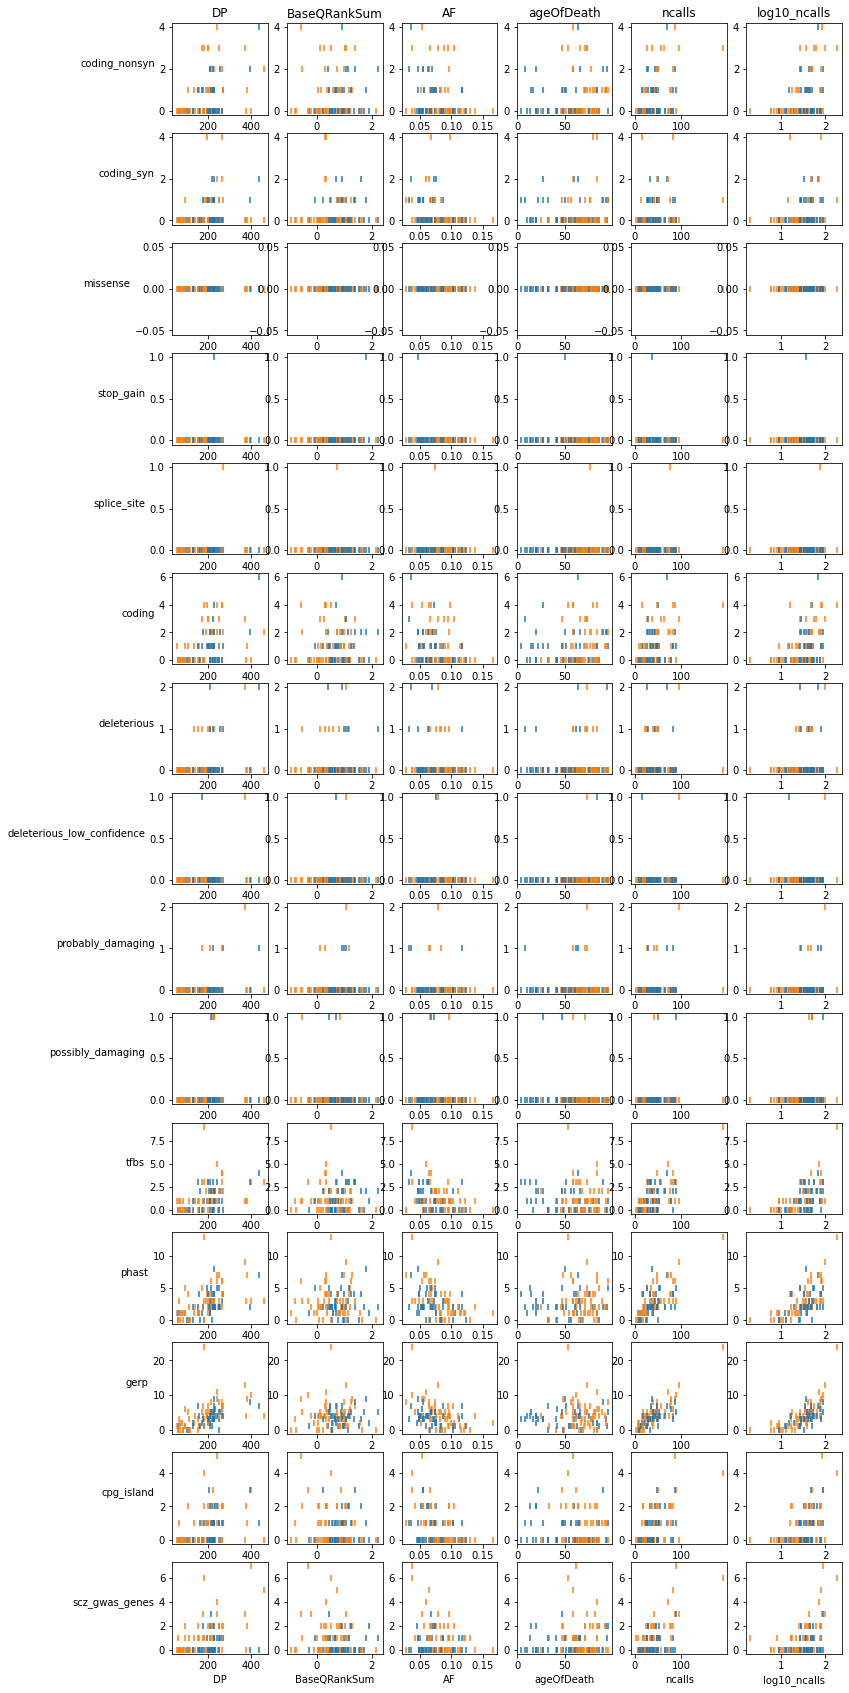

In [16]:
fig, ax = ncalls_categ_predictors_plot(fitdata_scz, responses_scz, covariates_scz)
attila_utils.savefig(fig, 'ncalls-func-categ-predictors_scz')

### More transformations

['named-figure/DP-AF-log10-transform.png',
 'named-figure/DP-AF-log10-transform.pdf']

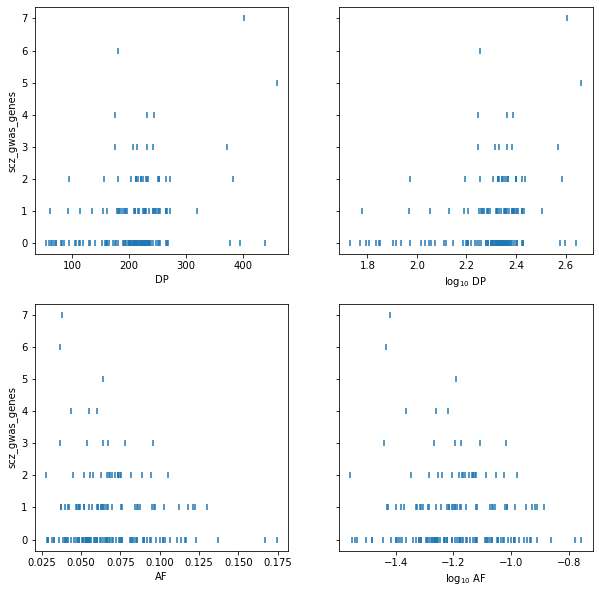

In [17]:
%matplotlib inline

def more_transform_plot(responses, covariates):
    features = ['DP', 'AF']
    fig, ax = plt.subplots(len(features), 2, figsize=(10, 10), sharey=True)
    for i, feature in zip(range(len(features)), features):
        ax[i, 0].scatter(y=responses['scz_gwas_genes'], x=covariates[feature], marker='|')
        ax[i, 0].set_ylabel('scz_gwas_genes')
        ax[i, 0].set_xlabel(feature)
        ax[i, 1].scatter(y=responses['scz_gwas_genes'], x=np.log10(covariates[feature]), marker='|')
        ax[i, 1].set_xlabel('$\log_{10}$ ' + feature)
    return((fig, ax))

fig, ax = more_transform_plot(responses, covariates)
attila_utils.savefig(fig, 'DP-AF-log10-transform')

Now without the ASD individuals

['named-figure/DP-AF-log10-transform_scz.png',
 'named-figure/DP-AF-log10-transform_scz.pdf']

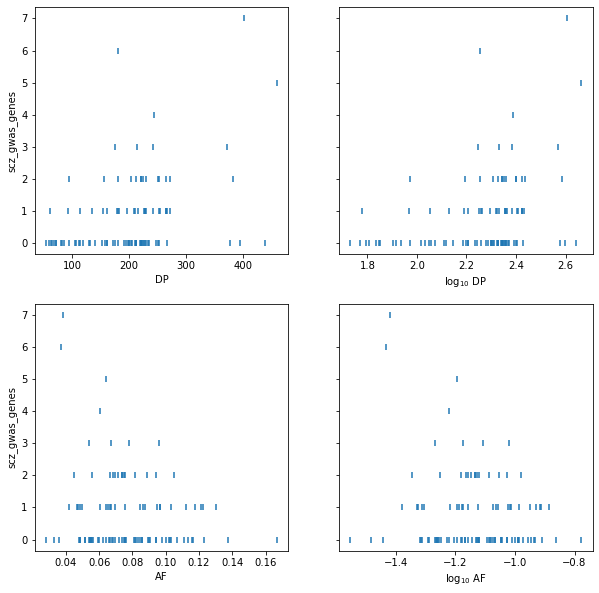

In [18]:
fig, ax = more_transform_plot(responses_scz, covariates_scz)
attila_utils.savefig(fig, 'DP-AF-log10-transform_scz')

### Response: proportion of calls in func categ

In this case we take the proportion, for each individual, of the following two counts:
1. the number calls in some functional category and
1. the genome wide number of calls

The advantage of this definition of response over the previous one is that now we directly condition the first variable on the second for each individual.

['named-figure/prop_calls-func-categ-predictors.png',
 'named-figure/prop_calls-func-categ-predictors.pdf']

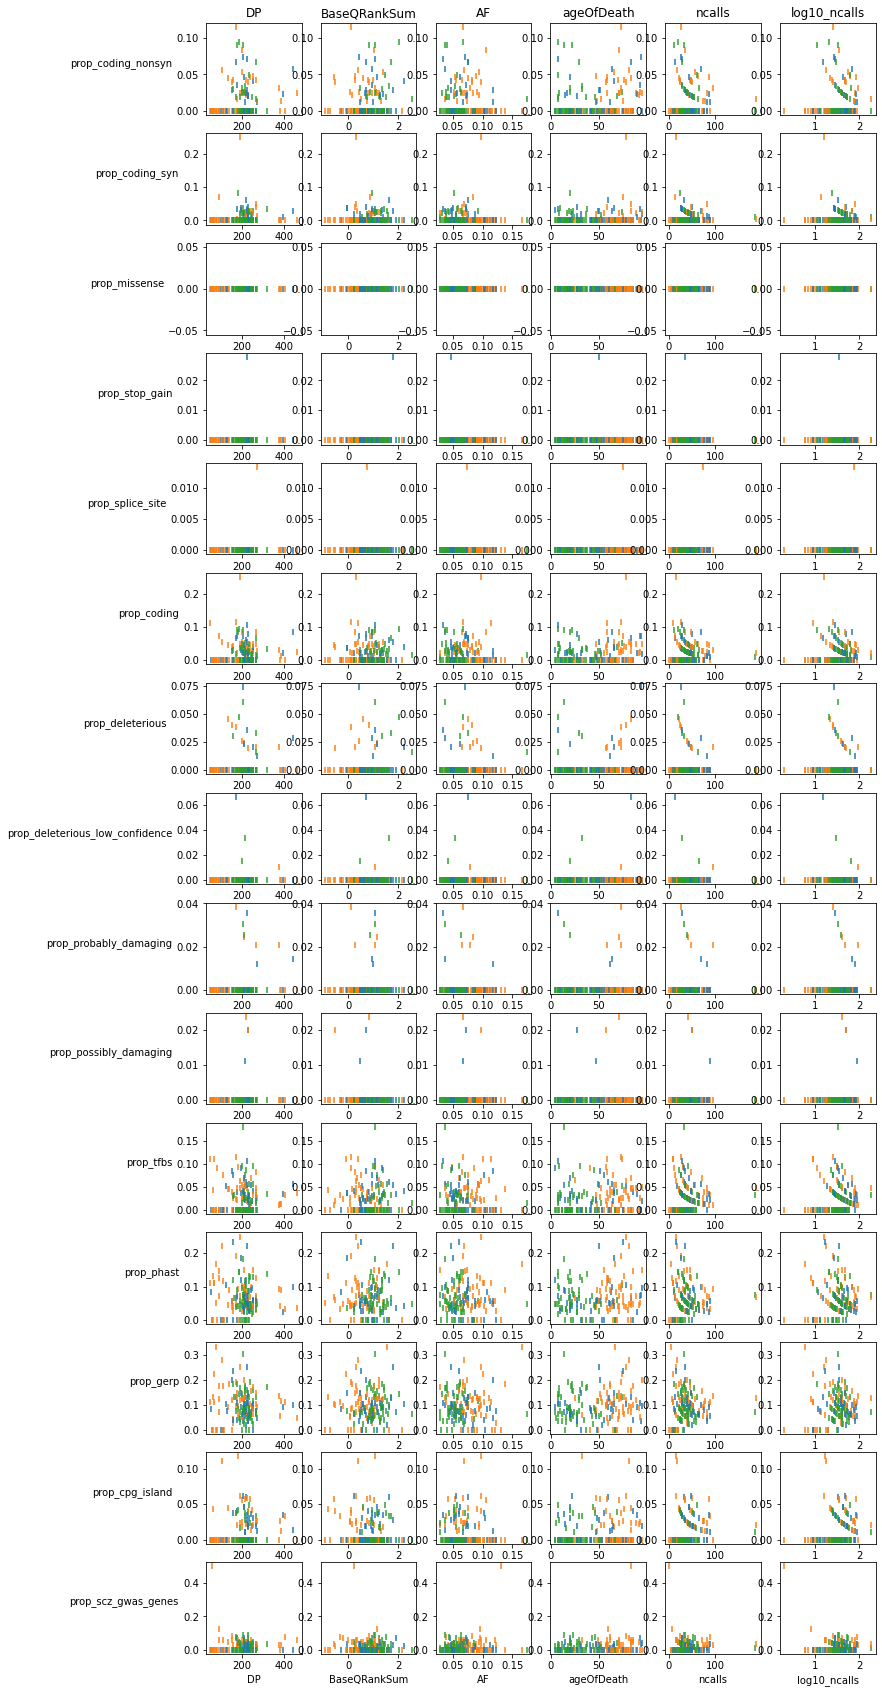

In [19]:
fig, ax = icm.big_plot_matrix(responses_prop, covariates, getDxcol(fitdata))
attila_utils.savefig(fig, 'prop_calls-func-categ-predictors')

Repeat without the ASD individuals

['named-figure/prop_calls-func-categ-predictors_scz.png',
 'named-figure/prop_calls-func-categ-predictors_scz.pdf']

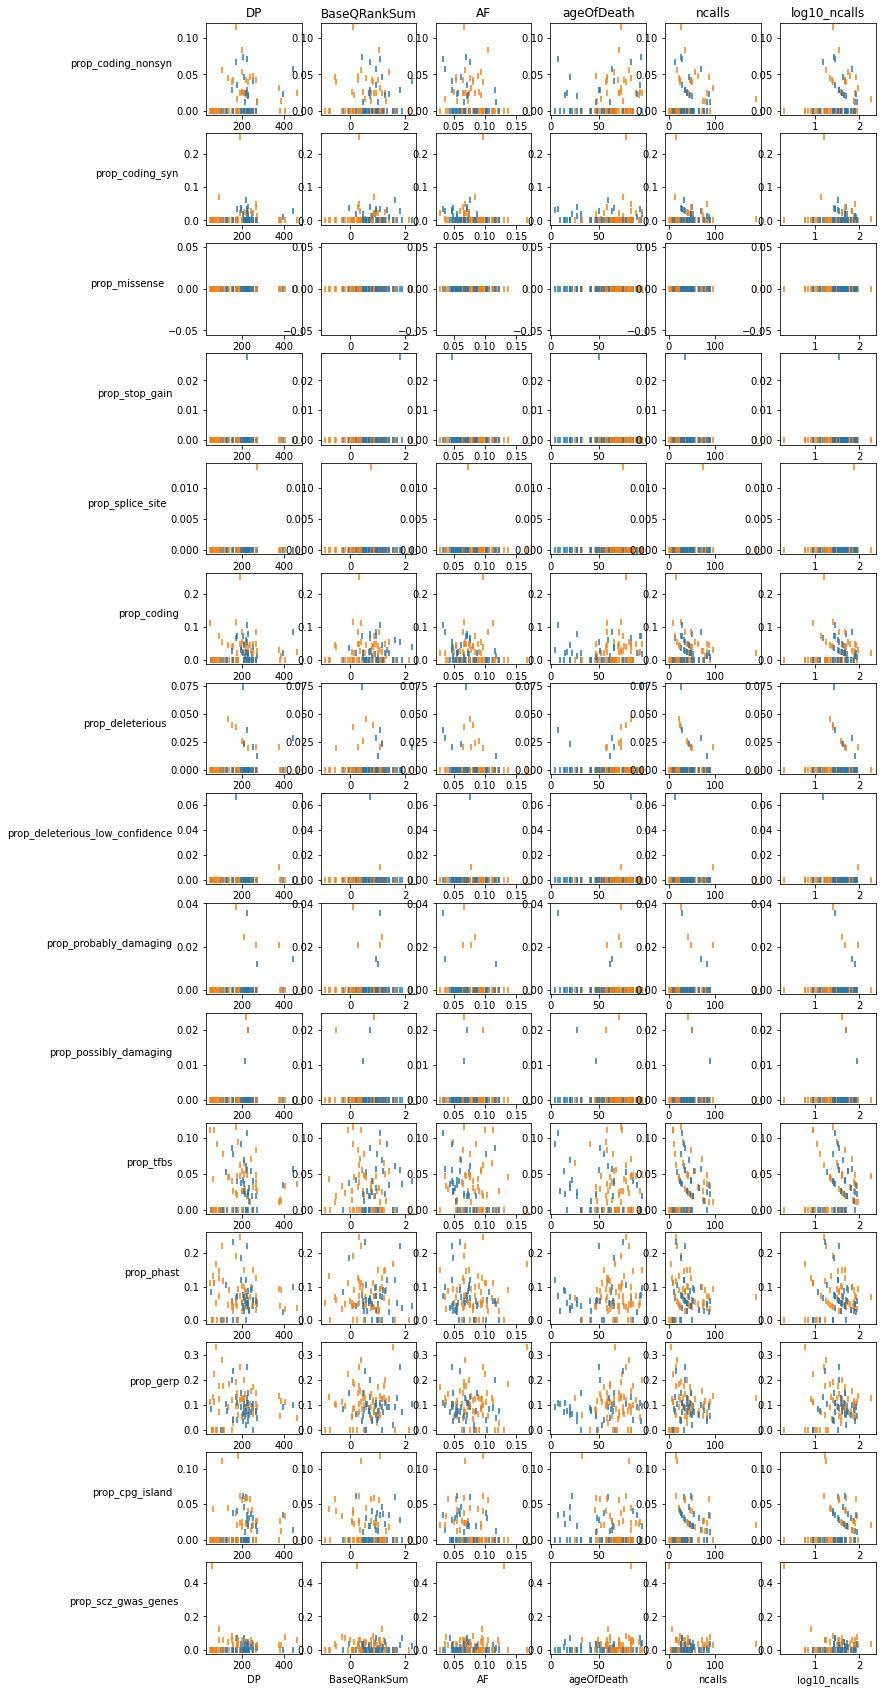

In [20]:
fig, ax = icm.big_plot_matrix(responses_prop_scz, covariates_scz, getDxcol(fitdata_scz))
attila_utils.savefig(fig, 'prop_calls-func-categ-predictors_scz')

## Training data for fitting models

First simplify column names and create data matrix

In [21]:
def endog_binomial(feature, fitdata=fitdata, proportion=False):
    success = fitdata[feature]
    if proportion:
        prop = success / fitdata['ncalls']
        return(prop)
    failure = fitdata['ncalls'] - success
    complement = 'NOT_' + feature
    df = pd.DataFrame({feature: success, complement: failure})
    return(df)

## `scz_gwas_genes`: log linear (Poisson) models

These models are fitted on the count type response: the number of calls within a functional category.  The genome wide number of calls `ncalls` enters the regression model as a covariate

['named-figure/scz_gwas_genes-log10_ncalls-poisson-fit.png',
 'named-figure/scz_gwas_genes-log10_ncalls-poisson-fit.pdf']

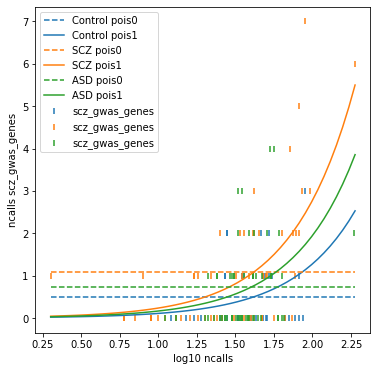

In [22]:
def get_Dxd(fitdata):
    A = {'Control': (0, 0), 'SCZ': (1, 0), 'ASD': (0, 1)}
    B = {'Control': (0,), 'SCZ': (1,)}
    Dxd = A if 'ASD' in fitdata['Dx'].cat.categories else B
    return(Dxd)

def poisson_plot(fitdata):
    formula0 = 'scz_gwas_genes ~ Dx'
    y0, X0 = patsy.dmatrices(formula0, data=fitdata, return_type='dataframe')
    pois0 = sm.GLM(endog=y0, exog=X0, family=sm.families.Poisson()).fit()
    formula1 = 'scz_gwas_genes ~ Dx + log10_ncalls'
    y1, X1 = patsy.dmatrices(formula1, data=fitdata, return_type='dataframe')
    pois1 = sm.GLM(endog=y1, exog=X1, family=sm.families.Poisson()).fit()
    fig, ax = plt.subplots(figsize=(6, 6))
    left = fitdata['log10_ncalls'].min()
    right = fitdata['log10_ncalls'].max()
    log10_ncalls_test = np.linspace(left, right)
    Dxd = get_Dxd(fitdata)
    l = ['C' + str(x) for x in range(len(fitdata['Dx'].cat.categories))]
    for color, Dx in zip(l, fitdata['Dx'].cat.categories):
        y0_pred = pois0.predict([1, *Dxd[Dx]])
        ax.plot([left, right], [y0_pred] * 2, linestyle='dashed', label=Dx + ' pois0')
        X_test = pd.DataFrame(dict(zip(X1.columns, [1, *Dxd[Dx], log10_ncalls_test])))
        ax.scatter(x='log10_ncalls', y='scz_gwas_genes', data=fitdata.loc[fitdata['Dx'] == Dx], marker='|', color=color)
        ax.plot(log10_ncalls_test, pois1.predict(X_test), color=color, label=Dx + ' pois1')
    ax.legend()
    ax.set_xlabel('log10 ncalls')
    ax.set_ylabel('ncalls scz_gwas_genes')
    return((fig, ax))

pois0, Dxd = poisson_plot(fitdata)
attila_utils.savefig(fig, 'scz_gwas_genes-log10_ncalls-poisson-fit')

Now without ASD

['named-figure/scz_gwas_genes-log10_ncalls-poisson-fit_scz.png',
 'named-figure/scz_gwas_genes-log10_ncalls-poisson-fit_scz.pdf']

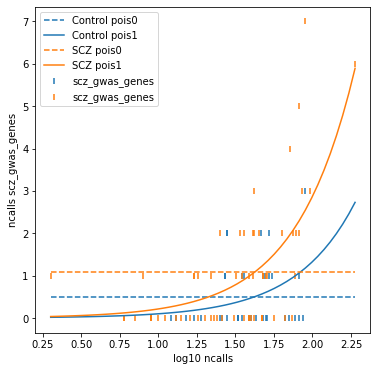

In [23]:
poisson_plot(fitdata_scz)
attila_utils.savefig(fig, 'scz_gwas_genes-log10_ncalls-poisson-fit_scz')

## `scz_gwas_genes`: logistic (binomial) models


In [24]:
y = endog_binomial('scz_gwas_genes', fitdata, proportion=True)
formula = 'Dx'
X0 = patsy.dmatrix(formula, data=fitdata, return_type='dataframe')
formula = 'Dx + ageOfDeath'
X1 = patsy.dmatrix(formula, data=fitdata, return_type='dataframe')
binom0 = sm.GLM(endog=y, exog=X0, family=sm.families.Binomial(), var_weights=fitdata['ncalls']).fit()
binom1 = sm.GLM(endog=y, exog=X1, family=sm.families.Binomial(), var_weights=fitdata['ncalls']).fit()

['named-figure/scz_gwas_genes-ageOfDeath-binom-fit-2panels.png',
 'named-figure/scz_gwas_genes-ageOfDeath-binom-fit-2panels.pdf']

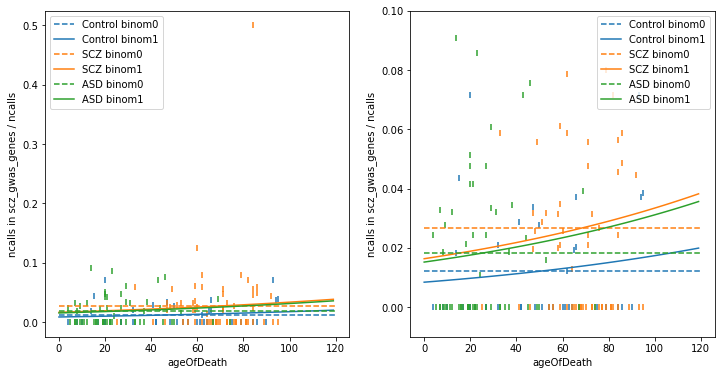

In [25]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

def binom_fit_plot(fig, ax, fitdata):
    y = endog_binomial('scz_gwas_genes', fitdata, proportion=True)
    formula0 = 'Dx'
    X0 = patsy.dmatrix(formula0, data=fitdata, return_type='dataframe')
    formula1 = 'Dx + ageOfDeath'
    X1 = patsy.dmatrix(formula, data=fitdata, return_type='dataframe')
    binom0 = sm.GLM(endog=y, exog=X0, family=sm.families.Binomial(), var_weights=fitdata['ncalls']).fit()
    binom1 = sm.GLM(endog=y, exog=X1, family=sm.families.Binomial(), var_weights=fitdata['ncalls']).fit()
    left = 0
    right = 120
    X_train = patsy.dmatrix(formula, data=fitdata, return_type='dataframe')
    ageOfDeath_test = np.arange(0, 120)
    proportion = icm.endog_binomial('scz_gwas_genes', fitdata, proportion=True)
    l = ['C' + str(x) for x in range(len(fitdata['Dx'].cat.categories))]
    Dxd = get_Dxd(fitdata)
    for color, Dx in zip(l, fitdata['Dx'].cat.categories):
        y0_pred = binom0.predict([1, *Dxd[Dx]])
        X_test = pd.DataFrame(dict(zip(X_train.columns, [1, *Dxd[Dx], ageOfDeath_test])))
        def myplot(ax):
            ax.scatter(y=proportion.loc[fitdata['Dx'] == Dx], x=fitdata.loc[fitdata['Dx'] == Dx, 'ageOfDeath'], marker='|', color=color)
            ax.plot([left, right], [y0_pred] * 2, linestyle='dashed', label=Dx + ' binom0')
            ax.plot(ageOfDeath_test, binom1.predict(X_test), color=color, label=Dx + ' binom1')
            ax.set_ylabel('ncalls in scz_gwas_genes / ncalls')
            ax.set_xlabel('ageOfDeath')
            ax.legend()
            return(ax)
        for axi in fig.axes:
            myplot(axi)
    return(fig, ax)

#l, Dxd = binom_fit_plot(fig, ax, fitdata_scz)
fig, ax = binom_fit_plot(fig, ax, fitdata)
fig.axes[1].set_ylim([-0.01, 0.10])
attila_utils.savefig(fig, 'scz_gwas_genes-ageOfDeath-binom-fit-2panels')

['named-figure/scz_gwas_genes-ageOfDeath-binom-fit-2panels_scz.png',
 'named-figure/scz_gwas_genes-ageOfDeath-binom-fit-2panels_scz.pdf']

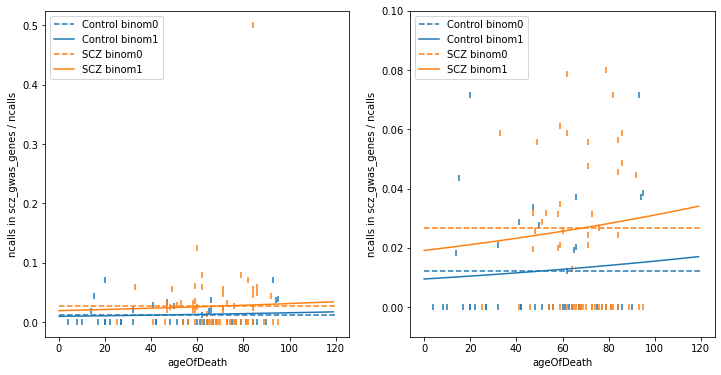

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig, ax = binom_fit_plot(fig, ax, fitdata_scz)
fig.axes[1].set_ylim([-0.01, 0.10])
attila_utils.savefig(fig, 'scz_gwas_genes-ageOfDeath-binom-fit-2panels_scz')

['named-figure/scz_gwas_genes-ageOfDeath-binom-fit.png',
 'named-figure/scz_gwas_genes-ageOfDeath-binom-fit.pdf']

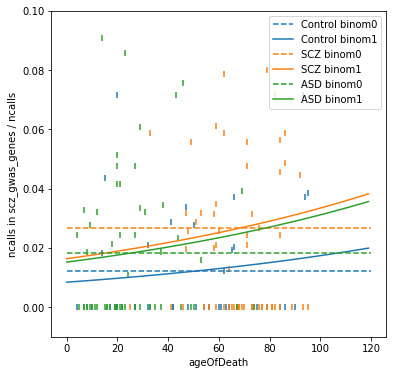

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig, ax = binom_fit_plot(fig, ax, fitdata)
fig.axes[0].set_ylim([-0.01, 0.10])
attila_utils.savefig(fig, 'scz_gwas_genes-ageOfDeath-binom-fit')

['named-figure/scz_gwas_genes-ageOfDeath-binom-fit_scz.png',
 'named-figure/scz_gwas_genes-ageOfDeath-binom-fit_scz.pdf']

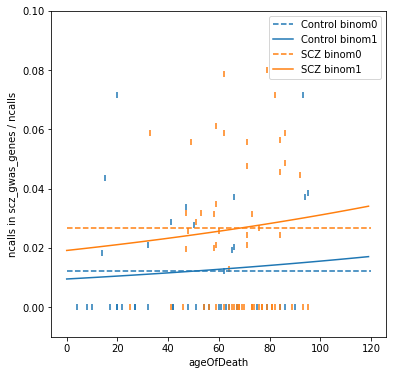

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig, ax = binom_fit_plot(fig, ax, fitdata_scz)
fig.axes[0].set_ylim([-0.01, 0.10])
attila_utils.savefig(fig, 'scz_gwas_genes-ageOfDeath-binom-fit_scz')

## `scz_gwas_genes`: model selection

The partial residual plots reveal that the biggest outlier is actually an SCZ individual CMC_MSSM_201 with only one calls in SCZ GWAS genes and two calls genome wide.

In [29]:
exogs = ['log10_ncalls', 'Dx', 'ageOfDeath', 'BaseQRankSum', 'Dataset', 'AF', 'DP']
pois_modsel = icm.multifit(fitdata, 'scz_gwas_genes', exogs, sm.families.Poisson(), do_fwsel=True)
exogs.remove('log10_ncalls')
binom_modsel = icm.multifit(fitdata, 'scz_gwas_genes', exogs, sm.families.Binomial(), do_fwsel=True)

['named-figure/scz_gwas_genes-fw-varsel-pois.png',
 'named-figure/scz_gwas_genes-fw-varsel-pois.pdf']

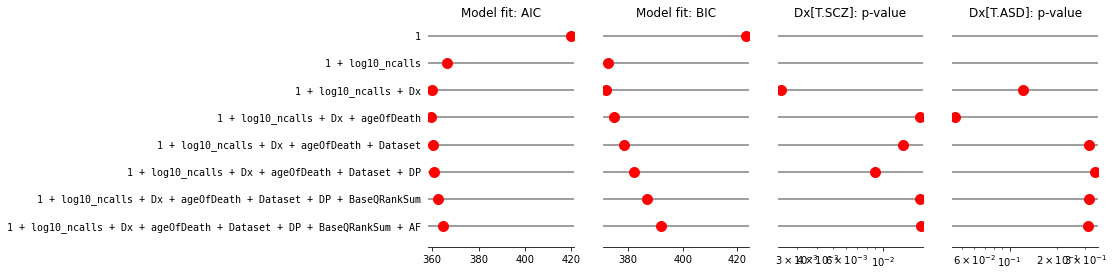

In [30]:
%matplotlib inline
fig, ax = icm.modsel_dotplot(pois_modsel)
attila_utils.savefig(fig, 'scz_gwas_genes-fw-varsel-pois')

['named-figure/scz_gwas_genes-fw-varsel-pois-onlyIC.png',
 'named-figure/scz_gwas_genes-fw-varsel-pois-onlyIC.pdf']

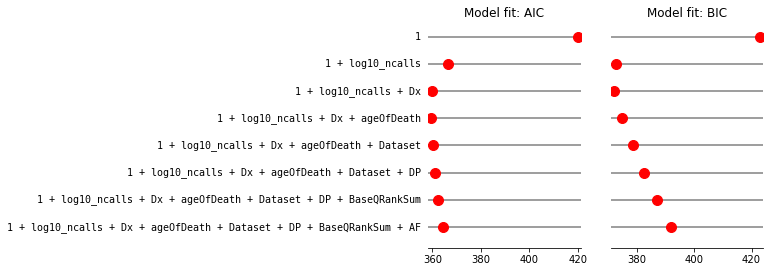

In [31]:
fig, ax = icm.modsel_dotplot(pois_modsel, onlyIC=True)
attila_utils.savefig(fig, 'scz_gwas_genes-fw-varsel-pois-onlyIC')

['named-figure/scz_gwas_genes-fw-varsel-binom.png',
 'named-figure/scz_gwas_genes-fw-varsel-binom.pdf']

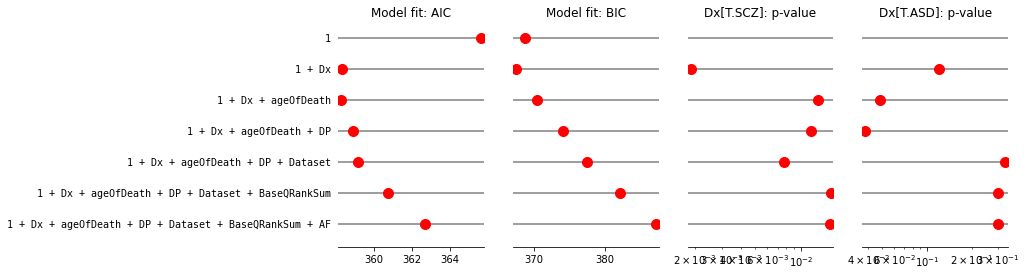

In [32]:
%matplotlib inline
fig, ax = icm.modsel_dotplot(binom_modsel)
attila_utils.savefig(fig, 'scz_gwas_genes-fw-varsel-binom')

['named-figure/scz_gwas_genes-fw-varsel-binom-onlyIC.png',
 'named-figure/scz_gwas_genes-fw-varsel-binom-onlyIC.pdf']

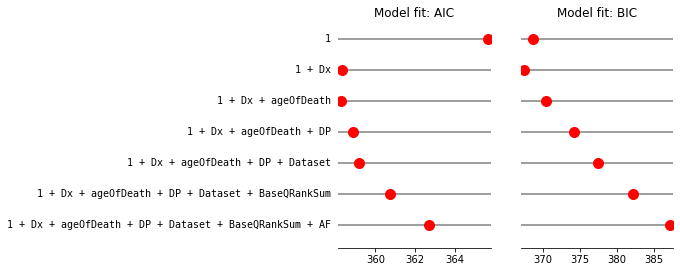

In [33]:
fig, ax = icm.modsel_dotplot(binom_modsel, onlyIC=True)
attila_utils.savefig(fig, 'scz_gwas_genes-fw-varsel-binom-onlyIC')

## All functional categories: model selection

Below are the results of forward variable selection given each functional category and each model family (Poisson, binomial).  `nindiv | ncalls_f > 0` is the number of individuals with at least one somatic variant call in the given functional category.  More such individuals means more observations to fit the models onto and therefore more complex models are supported by those data sets.  Note the good agreement between the Poisson and binomial models.

In [34]:
endogs = responses.columns
def safely_fit(endog, exogs, family):
    if fitdata[endog].value_counts()[1:].sum() < 3:
        return((None, None))
    try:
        modsel = icm.multifit(fitdata, endog, exogs, family, do_fwsel=True)
        sel_formula = pd.Series(modsel).apply(lambda m: m.aic).sort_values().index[0]
        val = (sel_formula, modsel[sel_formula])
    except ValueError:
        val = ((None, None))
    return(val)

exogs = ['log10_ncalls', 'Dx', 'ageOfDeath', 'BaseQRankSum', 'Dataset', 'AF', 'DP']
pois_varsel = {endog: safely_fit(endog, exogs, sm.families.Poisson()) for endog in endogs}

In [35]:
exogs.remove('log10_ncalls')
binom_varsel = {endog: safely_fit(endog, exogs, sm.families.Binomial()) for endog in endogs}

In [36]:
def edit_fit_results(d, colname='poisson'):
    l = [pd.Series(d).apply(lambda x: x[i]) for i in [0, 1]]
    columns = pd.MultiIndex.from_product([[colname], ['formula', 'model']])
    df = pd.DataFrame(np.array(l).T, columns=columns, index=d.keys())
    return(df)

varsel = pd.concat([edit_fit_results(d, name) for name, d in zip(['poisson', 'binomial'], [pois_varsel, binom_varsel])], axis=1)
varsel['nindiv | ncalls_f > 0'] = responses.apply(lambda x: x.value_counts()[1:].sum(), axis=0)
varsel.iloc[:, ::2].sort_values('nindiv | ncalls_f > 0')

,poisson,binomial,nindiv | ncalls_f > 0
,formula,formula,
missense,None,None,0
stop_gain,None,None,1
splice_site,None,None,1
deleterious_low_confidence,1,1,4
possibly_damaging,1 + log10_ncalls + BaseQRankSum,1 + BaseQRankSum,4
probably_damaging,1 + DP,1 + DP,9
deleterious,1 + DP,1 + BaseQRankSum + Dataset,19
coding_syn,1 + log10_ncalls + ageOfDeath + AF,1 + ageOfDeath + AF,38
coding_nonsyn,1 + log10_ncalls + Dataset + BaseQRankSum,1 + Dataset + BaseQRankSum,55


## All functional categories: results

The dot plots below show results for the best fitting Poisson (red) and binomial (blue) models across all functional categories.  The regression coefficient estimate for the $j$-th parameter is $\hat{\beta_j}$.  Where the variable corresponding to the $j$-th parameter was not selected by the forward algorithm I present the theoretical null values: 0 for $\beta_j$ and 1 for the $j$-th $p$-value.

For categorical variables these estimates and and $p$-values are complemented by the predicted fold enrichment based on the Poisson models.  The latter is defined as

$$
\mathrm{enrichment} = \exp{\hat{\beta}_j}
$$
since
$$
\hat{\mu} \propto \exp \hat{\eta} = \exp (\hat{\beta}_1 x_1) \dotsm \exp \hat{\beta}_j \dotsm \exp (\hat{\beta}_p x_p) \propto \exp \hat{\beta}_j
$$

Here we exploited the property of the exponential function---inverse link function of the Poisson model---that it can be factorized according to $\beta_j x_j$ terms of the linear predictor $\eta = \sum_j \beta_j x_j$.  Such simple definition of enrichment is not possible for the binomial model because its inverse link funtion, the logistic function, is not permissible for similar factorization.  For that recall the definition of the logistic function: $f(x) = e^x / (1 + e^x) = (1 + e^{-x})^{-1}$.

['named-figure/scz-effect-pois-binom.png',
 'named-figure/scz-effect-pois-binom.pdf']

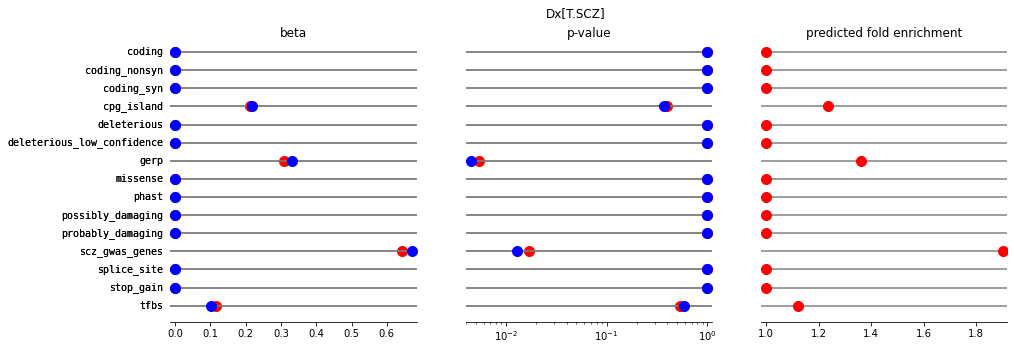

In [37]:
%matplotlib inline

def beta_pval_dotplot(params, pvals, suptitle, do_effsize=True):
    fig, ax = plt.subplots(1, 2 + do_effsize, figsize=(5 * (2 + do_effsize), 5))
    for color, family in zip(['red', 'blue'], params.columns):
        g = dotplots.dot_plot(params[family], lines=params.index, ax=ax[0], marker_props={0:{'color': color}})
        g = dotplots.dot_plot(pvals[family], lines=pvals.index, ax=ax[1], show_names='right', marker_props={0:{'color': color}})
        if do_effsize and family == 'poisson':
            g = dotplots.dot_plot(np.exp(params[family]), lines=params.index, ax=ax[2], show_names='right', marker_props={0:{'color': color}})
            ax[2].set_title('predicted fold enrichment')
    ax[0].set_title('beta')
    ax[1].set_title('p-value')
    ax[1].set_xscale('log')
    fig.suptitle(suptitle)
    return((fig, ax))

betas_SCZ = icm.apply2varsel(lambda m: m.params['Dx[T.SCZ]'], 0, varsel)
pvals_SCZ = icm.apply2varsel(lambda m: m.pvalues['Dx[T.SCZ]'], 1, varsel)
fig, ax = beta_pval_dotplot(betas_SCZ, pvals_SCZ, 'Dx[T.SCZ]')
attila_utils.savefig(fig, 'scz-effect-pois-binom')

['named-figure/asd-effect-pois-binom.png',
 'named-figure/asd-effect-pois-binom.pdf']

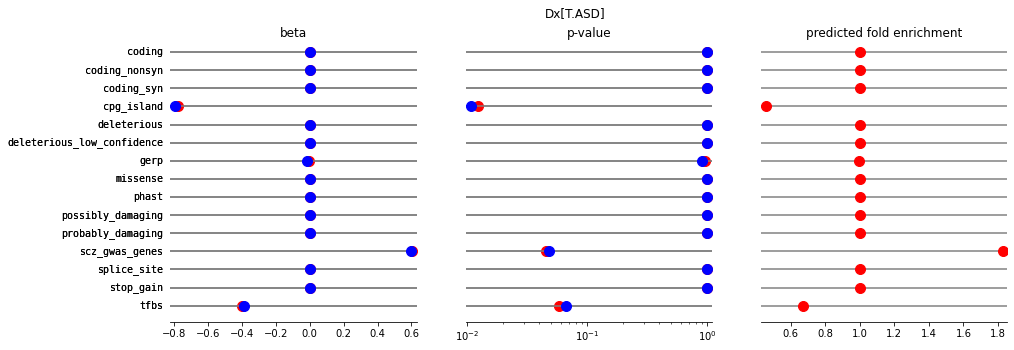

In [38]:
betas_ASD = icm.apply2varsel(lambda m: m.params['Dx[T.ASD]'], 0, varsel)
pvals_ASD = icm.apply2varsel(lambda m: m.pvalues['Dx[T.ASD]'], 1, varsel)
fig, ax = beta_pval_dotplot(betas_ASD, pvals_ASD, 'Dx[T.ASD]')
attila_utils.savefig(fig, 'asd-effect-pois-binom')

In [39]:
def merge_model_chisq(modeldfs=[pvals_SCZ, pvals_ASD], family='binomial'):
    l = [df[family] for df in modeldfs]
    df = pd.DataFrame(pd.concat(l, axis=1).to_numpy(), columns=['Dx[T.SCZ]', 'Dx[T.ASD]'])
    df.index = pvals_SCZ.index
    return(df)

binom_chisq_pvals = merge_model_chisq()
s = summary_chisq['chisq p']
s.index = binom_chisq_pvals.index
binom_chisq_pvals['chi^2'] = s
binom_chisq_pvals

,Dx[T.SCZ],Dx[T.ASD],chi^2
coding_nonsyn,1.000000,1.000000,0.106440
coding_syn,1.000000,1.000000,0.554924
missense,1.000000,1.000000,NaN
stop_gain,1.000000,1.000000,0.236044
splice_site,1.000000,1.000000,0.453210
coding,1.000000,1.000000,0.149989
deleterious,1.000000,1.000000,0.518131
deleterious_low_confidence,1.000000,1.000000,0.806613
probably_damaging,1.000000,1.000000,0.582566
possibly_damaging,1.000000,1.000000,0.290795


In [40]:
binom_betas = merge_model_chisq(modeldfs=[betas_SCZ, betas_ASD], family='binomial')

In [41]:
binom_chisq_pvals_rev = binom_chisq_pvals.reindex(reversed(binom_chisq_pvals.index))
callsperind = operations.summarize_query_mean_sem(results, data)
callsperind.index = binom_chisq_pvals.index
callsperind = callsperind.reindex(binom_chisq_pvals.index)
stdcpi = callsperind.sort_values(('Control', 'mean'), ascending=True).apply(lambda x: x / x[('Control', 'mean')], axis=1).dropna()
stdcpi = stdcpi.reindex(binom_chisq_pvals.index)
ncalls_tot = pd.Series(summary.sum(axis=1).to_numpy(), index=binom_chisq_pvals.index)
ncalls_tot_rev = ncalls_tot.reindex(reversed(ncalls_tot.index))

['named-figure/enrichment-5-plots.png', 'named-figure/enrichment-5-plots.pdf']

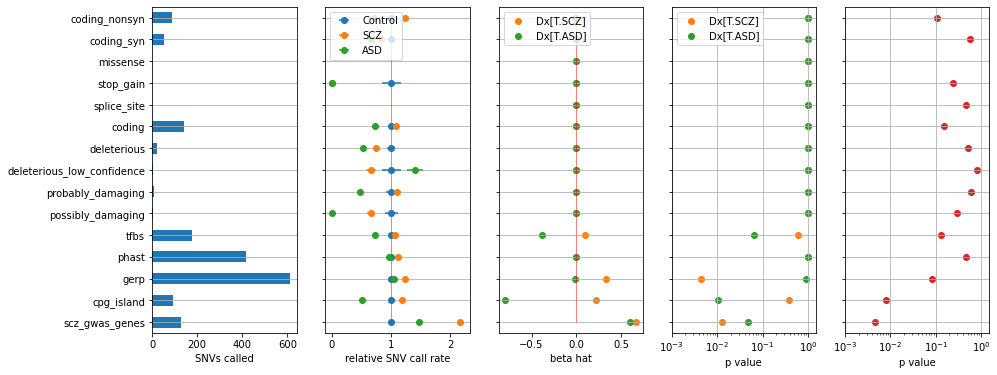

In [42]:
ticks = np.arange(len(binom_chisq_pvals))
yticklabels = list(reversed(binom_chisq_pvals.index))
stdcpirev = stdcpi.reindex(reversed(stdcpi.index))

def set_yticklabels(ax, yticks, yticklabels):
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    return(ax)

def pval_scatter_style(ax, yticks, yticklabels):
    ax = set_yticklabels(ax, yticks, yticklabels)
    ax.set_xlim(1e-3, 1.5)
    ax.set_xscale('log')
    ax.set_xticks([1e-3, 1e-2, 1e-1, 1e0])
    ax.grid(True, axis='both')
    ax.set_xlabel('p value')
    return(ax)

def ncalls_scatter(ax):
    ncalls_tot_rev.plot(kind='barh', ax=ax)
    ax.grid(True, axis='y')
    ax.set_xlabel('SNVs called')
    return(ax)

def callrates_scatter(ax):
    x = stdcpirev.xs('mean', level=1, axis=1)
    error = stdcpirev.xs('sem', level=1, axis=1)
    for Dx, color in zip(x, ['C0', 'C1', 'C2']):
        ax.errorbar(x[Dx], ticks, xerr=error[Dx], fmt='o', color=color, label=Dx)
    ax.grid(True, axis='y')
    ax.plot([1, 1], [0, ticks[-1]], linestyle='solid', color='red', linewidth=0.5)
    ax.legend(loc='upper left')
    ax = set_yticklabels(ax, ticks, yticklabels)
    ax.set_xlabel('relative SNV call rate')
    return(ax)

def betas_scatter(ax):
    ax.scatter(betas_SCZ.reindex(stdcpirev.index)['binomial'], ticks, color='C1', label='Dx[T.SCZ]')
    ax.scatter(betas_ASD.reindex(stdcpirev.index)['binomial'], ticks, color='C2', label='Dx[T.ASD]')
    ax.grid(True, axis='y')
    ax.plot([0, 0], [0, ticks[-1]], linestyle='solid', color='red', linewidth=0.5)
    ax = set_yticklabels(ax, ticks, yticklabels)
    ax.legend(loc='upper left')
    ax.set_xlabel('beta hat')
    return(ax)

def beta_pval_scatter(ax):
    for term, color in zip(['Dx[T.SCZ]', 'Dx[T.ASD]'], ['C1', 'C2']):
        ax.scatter(binom_chisq_pvals_rev[term], ticks, label=term, color=color)
    ax.legend()
    ax = pval_scatter_style(ax, ticks, yticklabels)
    return(ax)

def chisq_pval_scatter(ax):
    ax.scatter(binom_chisq_pvals_rev['chi^2'], ticks, color='C3')
    ax = pval_scatter_style(ax, ticks, yticklabels)
    return(ax)

fig, ax = plt.subplots(1, 5, figsize=(15, 6), sharey=True, sharex=False)
ax[0] = ncalls_scatter(ax[0])
ax[1] = callrates_scatter(ax[1])
ax[2] = betas_scatter(ax[2])
ax[3] = beta_pval_scatter(ax[3])
ax[4] = chisq_pval_scatter(ax[4])
attila_utils.savefig(fig, 'enrichment-5-plots')

['named-figure/enrichment-chisq.png', 'named-figure/enrichment-chisq.pdf']

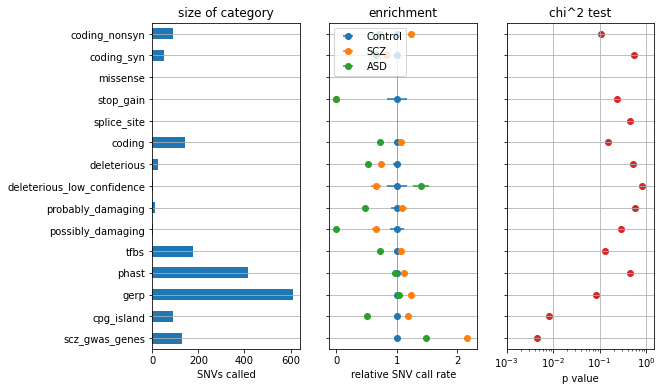

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(9, 6), sharey=True, sharex=False)
ax[0] = ncalls_scatter(ax[0])
ax[1] = callrates_scatter(ax[1])
ax[2] = chisq_pval_scatter(ax[2])
ax[0].set_title('size of category')
ax[1].set_title('enrichment')
ax[2].set_title('chi^2 test')
attila_utils.savefig(fig, 'enrichment-chisq')

['named-figure/enrichment-model-chisq.png',
 'named-figure/enrichment-model-chisq.pdf']

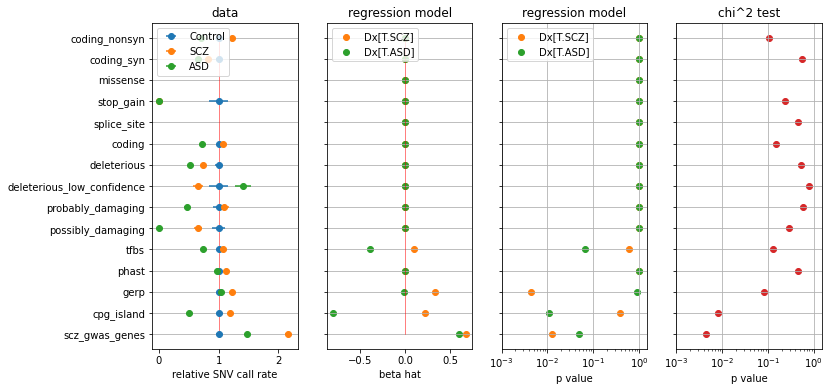

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(12, 6), sharey=True, sharex=False)
ax[0] = callrates_scatter(ax[0])
ax[1] = betas_scatter(ax[1])
ax[2] = beta_pval_scatter(ax[2])
ax[3] = chisq_pval_scatter(ax[3])
ax[0].set_title('data')
ax[1].set_title('regression model')
ax[2].set_title('regression model')
ax[3].set_title('chi^2 test')
attila_utils.savefig(fig, 'enrichment-model-chisq')

['named-figure/age-effect-pois-binom.png',
 'named-figure/age-effect-pois-binom.pdf']

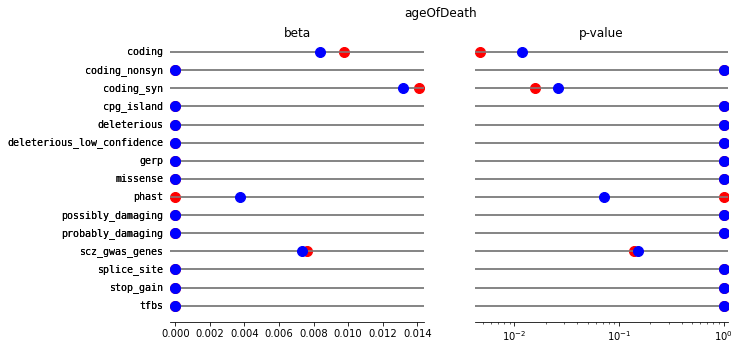

In [45]:
x = icm.apply2varsel(lambda m: m.params['ageOfDeath'], 0, varsel)
y = icm.apply2varsel(lambda m: m.pvalues['ageOfDeath'], 1, varsel)
fig, ax = beta_pval_dotplot(x, y, 'ageOfDeath', False)
attila_utils.savefig(fig, 'age-effect-pois-binom')

## Checking model fit

There are several types of residuals in use for generalized linear models.  The $r^\ast$ residual is approximately normally distributed even if the error distribution for the model family is not normal, such as Poisson or binomial.  This residual is defined (see A.C Davison Statistical Models Ch10.2 p477) as follows
$$
r^\ast = r_\mathrm{D} + r_\mathrm{D}^{-1} \log \frac{r_\mathrm{P}}{r_\mathrm{D}}
$$

['named-figure/binom-four-resid-types.png',
 'named-figure/binom-four-resid-types.pdf']

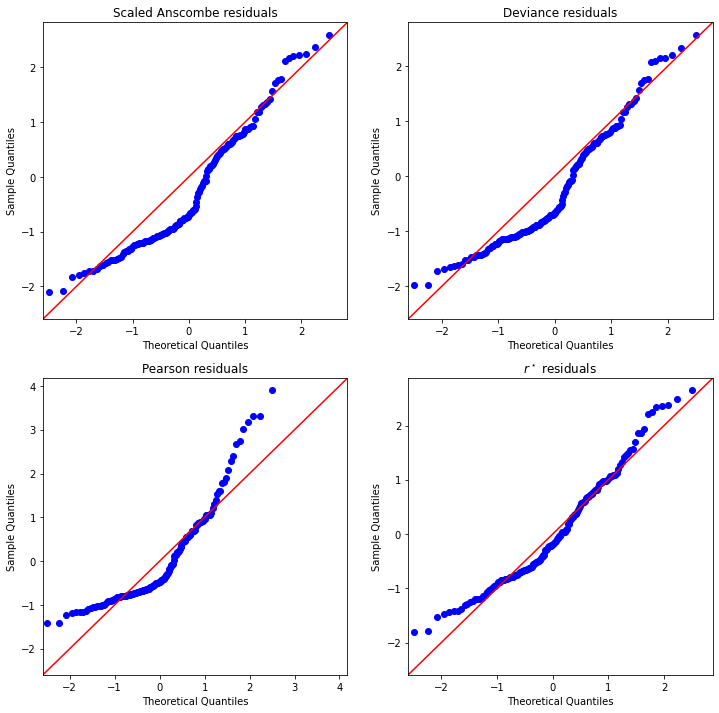

In [46]:
fig, ax = icm.QQ_four_residual_types(varsel.loc['scz_gwas_genes', ('binomial', 'model')])
attila_utils.savefig(fig, 'binom-four-resid-types')

The two plot matrices below show that increasing number of non-null observations improve model fit both for the Poisson and the binomial family.  The latter seems to fit the data slightly better.

['named-figure/resid-pois.png', 'named-figure/resid-pois.pdf']

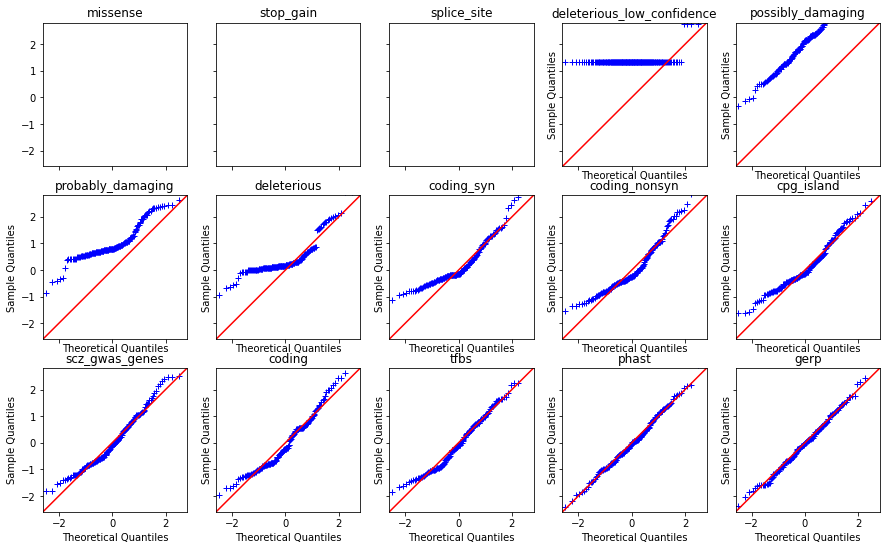

In [47]:
fig, ax = icm.QQ_rstar_residual(varsel.sort_values('nindiv | ncalls_f > 0').loc[:, ('poisson', 'model')])
attila_utils.savefig(fig, 'resid-pois')

['named-figure/resid-binom.png', 'named-figure/resid-binom.pdf']

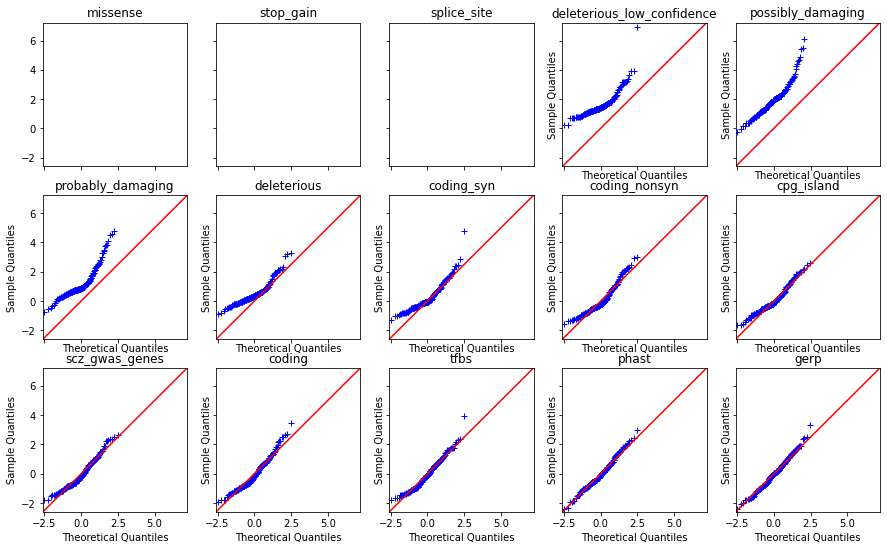

In [48]:
fig, ax = icm.QQ_rstar_residual(varsel.sort_values('nindiv | ncalls_f > 0').loc[:, ('binomial', 'model')])
attila_utils.savefig(fig, 'resid-binom')

NameError: name 'pois1' is not defined

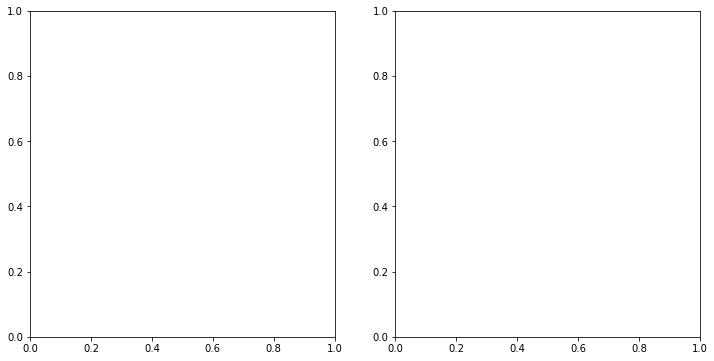

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
g = pois1.plot_partial_residuals('log10_ncalls', ax=ax[0])
g = pois1.plot_partial_residuals('log10_ncalls', ax=ax[1])
ax[1].set_ylim(0, 10)
attila_utils.savefig(fig, 'scz_gwas_genes-poisson-partial-resid-plot')

In [ ]:
%connect_info